# Задача 1 
Посчитать численно $DV01$ как разностную производную.
1. Номер выпуска облигации определяет функция getBond ниже 
1. Процентные ставки известны ниже curve_tenors, curve_rates
1. Использоватье линейную интерполяцию кубическими сплайнами (см. пример ниже)

$$ PV  = PV (r_1, r_2, r_3, ..., r_N) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i)^{t_i}} $$
где $r_i$ - значение ставки, $C_i$ - выплата в день купонного платежа под номером $i$

$$ DV01 (r_1, r_2,  ..., r_N) = \lim \limits_{\delta \to 0} \frac{PV (r_1 + \delta r, r_2 + \delta r, ..., r_N + \delta r) - PV (r_1, r_2,  ..., r_N)}{\delta r}  \approx
\frac{PV (r_1 + \Delta r, r_2 + \Delta r, ..., r_N + \Delta r) - PV (r_1, r_2,  ..., r_N)}{\Delta r}$$

In [ ]:
def getBond(email):
    ccy = ['53004RMFS', '53003RMFS', '53005RMFS']
    h = hash(email)
    return ccy[h % len(ccy)]
getBond('maxpri2000@mail.ru')

'53004RMFS'

In [ ]:
import numpy as np
import scipy.interpolate

curve_tenors = np.array([0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0])
curve_rates = np.array([4.17,4.21,4.26,4.32,4.59,4.88,5.41,5.83,6.26,6.62,6.79,6.98])*1e-2

f = scipy.interpolate.interp1d(curve_tenors, curve_rates, kind = 'cubic')
f(np.array([10, 20, 30]) / 12) # пример ставки на 10M, 20M, 30M

array([0.04279136, 0.04496374, 0.04734704])

In [ ]:
import pandas as pd
import datetime
import scipy.optimize

## Сегодняшняя дата 18.03.2021
## Для 53005RMFS (такой номер был при вызове getBond в начале работы)

https://www.moex.com/ru/issue.aspx?board=PSBB&code=SU53005RMFS3#/bond_4

0.	18.03.2021	- Price : 96.932% от номинала
1.	21.07.2021	182	5,25%	25,93
2.	19.01.2022	182	5,25%	26,18
3.	20.07.2022	182	5,30%	26,43
4.	18.01.2023	182	5,41%	1026.98

In [ ]:
t0 = datetime.date(2021, 3, 18)

t1 = datetime.date(2021, 7, 21)
t2 = datetime.date(2022, 1, 19)
t3 = datetime.date(2022, 7, 20)
t4 = datetime.date(2023, 1, 18)

t_last_coupon = datetime.date(2021, 1, 20)

delta1 = (t1 - t0).days
delta2 = (t2 - t0).days
delta3 = (t3 - t0).days
delta4 = (t4 - t0).days

delta_last_coupon = (t0 - t_last_coupon).days 
new_coupon = delta_last_coupon / 182 * 25.93

payments = np.array([25.93, 26.18, 26.43, 1026.98])
days = np.array([delta1, delta2, delta3, delta4])

Price = 96.932 * 1000 / 100 + new_coupon#dirty price

In [ ]:
def ytm(days, payments, ytm):
    days = days / 365  # use the right day count
    df = np.power(1.0 / (ytm + 1.0), days)
    return np.sum(payments*df)

ytm = scipy.optimize.broyden1( lambda x: (ytm(days, payments, x) - Price)**2, 0.0475)
ytm

array(0.07225456)

In [ ]:
rates = f(np.array([5, 10, 16, 22]) / 12)
print('payments = ', payments)
print('rates = ', rates)
print('days: (date_i - 18.03.2021 ) = ', days)

payments =  [  25.93   26.18   26.43 1026.98]
rates =  [0.04195645 0.04279136 0.04406132 0.0454281 ]
days: (date_i - 18.03.2021 ) =  [125 307 489 671]


In [ ]:
def pv_ytm(days, payments, rates):
    days = days / 365  # use the right day count
    df = np.power(1.0 / (rates + 1.0), days)
    return np.sum(payments*df)

In [ ]:
def DV01(days, payments, rates, price, ytm, n):
    days = days / 365
    df = np.power(1.0 / (rates + 1.0), days)
    duration = np.sum(payments*df*days) / price
    mod_duration = duration / (1 + ytm/n)
    return (mod_duration * price)/ 10000  
DV_01 = DV01(days, payments, rates, Price, ytm, 2)
print('DV_01(def) = ', DV_01)

DV_01(def) =  0.1740448366266875


In [ ]:
dr = 1e-4
DV01 = 0.5 * ( pv_ytm(days, payments, rates + dr) - pv_ytm(days, payments, rates - dr))


print('DV01 = ', DV01)

DV01 =  -0.17250853936155863


Значения DV01, вычисленные по определению и численно - крайне близки. 

Значение DV01, полученное как производная = 0.172$ 

Т.е. рост доходности на 1 базисный пункт
приведет к убытку, равному 17.2 центам.

## Ответ:
DV01 = 0.172 $

# Задача 2

1. Таблица ниже описывает облигацию, необходимо ее захеджировать [ОФЗ](https://special.minfin.gov.ru/ru/document/?id_4=130822-parametry_obligatsii_federalnogo_zaima_dlya_fizicheskikh_lits_ofz-n_vypuska__53006rmfs) 

Использовать для расчета $DV01$ [кривую](https://www.moex.com/ru/marketdata/indices/state/g-curve/)

Чему равна $beta$?


| Date | Coupon |
|-------|-----------|
| 2021-02-24 | 34.9 |
| 2021-08-25 | 34.9|
| 2022-02-23 | 34.9|
| 2022-08-24 | 34.9 |
| 2023-02-22 | 34.9 |
| 2023-08-23 | 1034.9|

2. Построить график $PV$ портфеля от величины вертикального сдвига кривой $\Delta$
$$ PV (r; \Delta) = PV (r_1 + \Delta, r_2+ \Delta, r_3+ \Delta, ..., r_N+ \Delta) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i + \Delta)^{t_i}} $$





In [ ]:
import matplotlib.pyplot as plt

def pv(days, payments, rates, delta):
    days = days / 365  # use the right day count
    df = np.power(1.0 / (rates + delta + 1.0), days)
    return np.sum(payments*df)

Возьмём теноры ставок с сайта Мосбирже для 18.03.2021


In [ ]:
curve_tenors = np.array([0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 30.0])
curve_rates = np.array([4.95,4.98,5.06,5.16,5.64,6.08,6.66,6.98,7.20,7.37,7.46,7.55])*1e-2
f = scipy.interpolate.interp1d(curve_tenors, curve_rates, kind = 'cubic')

##Облигация

In [ ]:
t0 = datetime.date(2021, 3, 18)

t1 = datetime.date(2021, 8, 25)
t2 = datetime.date(2022, 2, 23)
t3 = datetime.date(2022, 8, 24)
t4 = datetime.date(2023, 2, 22)
t5 = datetime.date(2023, 8, 23)


t_last_coupon_trade = datetime.date(2021, 2, 24)

delta1_trade = (t1 - t0).days
delta2_trade = (t2 - t0).days
delta3_trade = (t3 - t0).days
delta4_trade = (t4 - t0).days
delta5_trade = (t5 - t0).days

delta_lc_trade = (t0 - t_last_coupon_trade).days 
new_coupon_trade = delta_lc_trade / 182 * 34.9

payments_trade = np.array([34.9, 34.98, 34.9, 34.9, 1034.9])
days_trade = np.array([delta1_trade, delta2_trade, delta3_trade, delta4_trade, delta5_trade])

Price_trade = 96.932 * 1000 / 100 + new_coupon_trade#dirty price

In [ ]:
print('days_trade = ',days_trade)
rates_trade  = f(np.array([6, 12, 18, 24, 30]) / 12)

days_trade =  [160 342 524 706 888]


## Хэджирующая облигация

In [ ]:
t0 = datetime.date(2021, 3, 18)

t1 = datetime.date(2021, 8, 4)
t2 = datetime.date(2022, 2, 2)
t3 = datetime.date(2022, 8, 3)
t4 = datetime.date(2023, 2, 1)
t5 = datetime.date(2023, 8, 2)


t_last_coupon_hedge = datetime.date(2021, 3, 2)

delta1_hedge = (t1 - t0).days
delta2_hedge = (t2 - t0).days
delta3_hedge = (t3 - t0).days
delta4_hedge = (t4 - t0).days
delta5_hedge = (t5 - t0).days

delta_lc_hedge = (t0 - t_last_coupon_hedge).days 
new_coupon_hedge = delta_lc_hedge / (t1 - t_last_coupon_hedge).days * 34.9

payments_hedge = np.array([21.94, 23.44, 24.93, 26.43, 1028.57])
days_hedge = np.array([delta1_hedge, delta2_hedge, delta3_hedge, delta4_hedge, delta5_hedge])

Price = 95,6470 * 1000 / 100 + new_coupon_hedge#dirty price

## Расчёт beta

In [ ]:
def pv_ytm_hedge(days, payments, rates):
    days = days / 365  # use the right day count
    df = np.power(1.0 / (rates + 1.0), days)
    return np.sum(payments*df)

In [ ]:
print('days_hedge = ',days_hedge)
rates_hedge  = f(np.array([5, 11, 17, 23, 29]) / 12)

days_hedge =  [139 321 503 685 867]


In [ ]:
dv01_trade = 0.5 * (pv_ytm_hedge(days_trade, payments_trade, rates_trade + dr) - pv_ytm_hedge(days_trade, payments_trade, rates_trade - dr))
dv01_hedge = 0.5 * (pv_ytm_hedge(days_hedge, payments_hedge, rates_hedge + dr) - pv_ytm_hedge(days_hedge, payments_hedge, rates_hedge - dr))
beta = - dv01_trade / dv01_hedge
beta

-1.04654628165828

PV = PV_Trade + beta*PV_hedge 

## График 

2. Построить график $PV$ портфеля от величины вертикального сдвига кривой $\Delta$
$$ PV (r; \Delta) = PV (r_1 + \Delta, r_2+ \Delta, r_3+ \Delta, ..., r_N+ \Delta) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i + \Delta)^{t_i}} $$

In [ ]:
r = np.arange(-0.1, 0.1, 1e-3)
pv = []
pv_trade = [] 
for y in r:
    pv += [pv_ytm_hedge(days_trade, payments_trade, rates_trade + y) + beta * pv_ytm_hedge(days_hedge, payments_hedge, rates_hedge + y)]
    pv_trade += [pv_ytm_hedge(days_trade, payments_trade, rates_trade + y)]

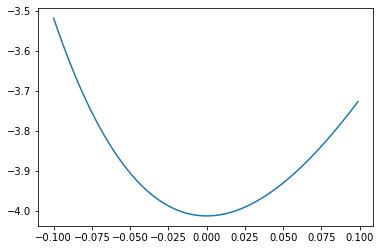

In [ ]:
plt.plot(r, pv) # portfolio pv
#plt.plot(r, pv_trade)

1. beta = -1.04654628165828
2. График(выше)